# Accelerate Stable Diffusion inference with DeepSpeed-Inference on GPUs

In this session, you will learn how to optimize Stable Diffusion for Inerence using  Hugging Face [🧨 Diffusers library](https://huggingface.co/docs/diffusers/index). and [DeepSpeed-Inference](https://www.deepspeed.ai/tutorials/inference-tutorial/). The session will show you how to apply state-of-the-art optimization techniques using [DeepSpeed-Inference](https://www.deepspeed.ai/tutorials/inference-tutorial/). 
This session will focus on single GPU (Ampere Generation) inference for Stable-Diffusion models.
By the end of this session, you will know how to optimize your Hugging Face Stable-Diffusion models using DeepSpeed-Inference. We are going to optimize [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4) for text-to-image generation.

You will learn how to:
1. [Setup Development Environment](#1-Setup-Development-Environment)
2. [Load vanilla Stable Diffusion model and set baseline](#2-Load-vanilla-Stable-Diffusion-model-and-set-baseline)
3. [Optimize Stable Diffusion for GPU using DeepSpeeds `InferenceEngine`](#3-Optimize-Stable-Diffusion-for-GPU-using-DeepSpeeds-InferenceEngine)
4. [Evaluate the performance and speed](#4-Evaluate-the-performance-and-speed)

Let's get started! 🚀

_This tutorial was created and run on a g5.xlarge AWS EC2 Instance including an NVIDIA A10G. The tutorial doesn't work on older GPUs, e.g. due to incompatibility of `triton` kernels._

---

## Quick Intro: What is DeepSpeed-Inference

[DeepSpeed-Inference](https://www.deepspeed.ai/tutorials/inference-tutorial/) is an extension of the [DeepSpeed](https://www.deepspeed.ai/) framework focused on inference workloads.  [DeepSpeed Inference](https://www.deepspeed.ai/#deepspeed-inference) combines model parallelism technology such as tensor, pipeline-parallelism, with custom optimized cuda kernels.
DeepSpeed provides a seamless inference mode for compatible transformer based models trained using DeepSpeed, Megatron, and HuggingFace. For a list of compatible models please see [here](https://github.com/microsoft/DeepSpeed/blob/master/deepspeed/module_inject/replace_policy.py).
As mentioned DeepSpeed-Inference integrates model-parallelism techniques allowing you to run multi-GPU inference for LLM, like [BLOOM](https://huggingface.co/bigscience/bloom) with 176 billion parameters.
If you want to learn more about DeepSpeed inference: 
* [Paper: DeepSpeed Inference: Enabling Efficient Inference of Transformer Models at Unprecedented Scale](https://arxiv.org/pdf/2207.00032.pdf)
* [Blog: Accelerating large-scale model inference and training via system optimizations and compression](https://www.microsoft.com/en-us/research/blog/deepspeed-accelerating-large-scale-model-inference-and-training-via-system-optimizations-and-compression/)


## 1. Setup Development Environment

Our first step is to install Deepspeed, along with PyTorch, Transfromers, Diffusers and some other libraries. Running the following cell will install all the required packages.

_Note: You need a machine with a GPU and a compatible CUDA installed. You can check this by running `nvidia-smi` in your terminal. If your setup is correct, you should get statistics about your GPU._

In [ ]:
!pip install torch==1.12.1 --extra-index-url https://download.pytorch.org/whl/cu116 --upgrade
!pip install deepspeed==0.7.4 --upgrade
!pip install diffusers==0.6.0 triton==2.0.0.dev20221005 --upgrade
!pip install transformers[sentencepiece]==4.24.0 accelerate --upgrade

Before we start. Let's make sure all packages are installed correctly.

In [3]:
import re
import torch 

# check deepspeed installation
report = !python3 -m deepspeed.env_report
r = re.compile('.*ninja.*OKAY.*')
assert any(r.match(line) for line in report) == True, "DeepSpeed Inference not correct installed"

# check cuda and torch version
torch_version, cuda_version = torch.__version__.split("+")
torch_version = ".".join(torch_version.split(".")[:2])
cuda_version = f"{cuda_version[2:4]}.{cuda_version[4:]}"
r = re.compile(f'.*torch.*{torch_version}.*')
assert any(r.match(line) for line in report) == True, "Wrong Torch version"
r = re.compile(f'.*cuda.*{cuda_version}.*')
assert any(r.match(line) for line in report) == True, "Wrong Cuda version"


## 2. Load vanilla Stable Diffusion model and set baseline

After we set up our environment, we create a baseline for our model. We use the [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4) checkpoint. 

Before we can load our model from the Hugging Face Hub we have to make sure that we accepted the license of [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4) to be able to use it. [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4) is published under the [CreativeML OpenRAIL-M license](https://huggingface.co/spaces/CompVis/stable-diffusion-license). You can accept the license by clicking on the `Agree and access repository` button on the model page at: https://huggingface.co/CompVis/stable-diffusion-v1-4. 

![license](../assets/license.png)

_Note: This will give access to the repository for the logged in user. This user can then be used to generate [HF Tokens](https://huggingface.co/settings/tokens) to load the model programmatically._


Before we can load the model make sure you have a valid [HF Token](https://huggingface.co/settings/token). You can create a token by going to your [Hugging Face Settings](https://huggingface.co/settings/token) and clicking on the `New token` button. Make sure the enviornment has enough diskspace to store the model, ~30GB should be enough.

In [ ]:
from diffusers import DiffusionPipeline
import torch

HF_MODEL_ID="CompVis/stable-diffusion-v1-4"
HF_TOKEN="" # your hf token: https://huggingface.co/settings/tokens
assert len(HF_TOKEN) > 0, "Please set HF_TOKEN to your huggingface token. You can find it here: https://huggingface.co/settings/tokens"

# load vanilla pipeline
pipeline = DiffusionPipeline.from_pretrained(HF_MODEL_ID, torch_dtype=torch.float16, revision="fp16",use_auth_token=HF_TOKEN)

# move pipeline to GPU
device = "cuda"
pipeline = pipeline.to(device)

We can now test our pipeline and generate an image

  0%|          | 0/51 [00:00<?, ?it/s]

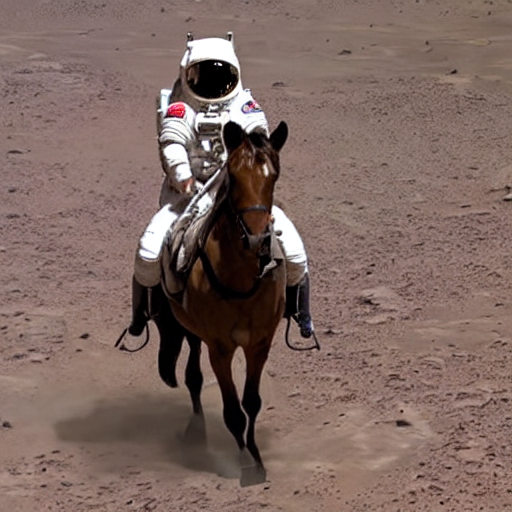

In [10]:
pipeline("a photo of an astronaut riding a horse on mars").images[0]  

The next step is to create a latency baseline we use the `measure_latency` function, which implements a simple python loop to run inference and calculate the avg, mean & p95 latency for our model.

In [17]:
from time import perf_counter
import numpy as np 


def measure_latency(pipe, prompt):
    latencies = []
    # warm up
    pipe.set_progress_bar_config(disable=True)
    for _ in range(2):
        _ =  pipe(prompt)
    # Timed run
    for _ in range(10):
        start_time = perf_counter()
        _ = pipe(prompt)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_s = np.mean(latencies)
    time_std_s = np.std(latencies)
    time_p95_s = np.percentile(latencies,95)
    return f"P95 latency (seconds) - {time_p95_s:.2f}; Average latency (seconds) - {time_avg_s:.2f} +\- {time_std_s:.2f};", time_p95_s

We are going to use the same prompt as we used in our example.

In [18]:
prompt = "a photo of an astronaut riding a horse on mars"

vanilla_results = measure_latency(pipeline,prompt)

print(f"Vanilla pipeline: {vanilla_results[0]}")

Vanilla pipeline: P95 latency (seconds) - 4.57; Average latency (seconds) - 4.56 +\- 0.00;


Our pipelines achieves latency of `4.57s` on a single GPU. This is a good baseline for our optimization.

## 3. Optimize Stable Diffusion for GPU using DeepSpeeds `InferenceEngine`

The next and most important step is to optimize our pipeline for GPU inference. This will be done using the DeepSpeed `InferenceEngine`. The `InferenceEngine` is initialized using the `init_inference` method. We are going to replace the `models` including the `UNET` and `CLIP` model in our pipeline with DeepSpeed optimized models.

The `init_inference` method expects as parameters atleast:
* `model`: The model to optimize, in our case the whole pipeline.
* `mp_size`: The number of GPUs to use.
* `dtype`: The data type to use.
* `replace_with_kernel_inject`: Whether inject custom kernels.

You can find more information about the `init_inference` method in the [DeepSpeed documentation](https://deepspeed.readthedocs.io/en/latest/inference-init.html) or [thier inference blog](https://www.deepspeed.ai/tutorials/inference-tutorial/).

_Note: You might need to restart your kernel if you are running into a CUDA OOM error._

In [ ]:
import torch
import deepspeed
from diffusers import DiffusionPipeline


# Model Repository on huggingface.co
HF_MODEL_ID="CompVis/stable-diffusion-v1-4"
HF_TOKEN="" # your hf token: https://huggingface.co/settings/tokens
assert len(HF_TOKEN) > 0, "Please set HF_TOKEN to your huggingface token. You can find it here: https://huggingface.co/settings/tokens"

# load vanilla pipeline
ds_pipeline = DiffusionPipeline.from_pretrained(HF_MODEL_ID, torch_dtype=torch.float16, revision="fp16",use_auth_token=HF_TOKEN)

# init deepspeed inference engine
deepspeed.init_inference(
    model=getattr(ds_pipeline,"model", ds_pipeline),      # Transformers models
    mp_size=1,        # Number of GPU
    dtype=torch.float16, # dtype of the weights (fp16)
    replace_method="auto", # Lets DS autmatically identify the layer to replace
    replace_with_kernel_inject=False, # replace the model with the kernel injector
)
print("DeepSpeed Inference Engine initialized")


We can now inspect a model graph to see that the vanilla `UNet2DConditionModel` has been replaced with an `DSUNet`, which includes the `DeepSpeedAttention` and `triton_flash_attn_kernel` module, custom `nn.Module` that is optimized for inference.

```python
DSUNet(
  (unet): UNet2DConditionModel(
    (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=320, out_features=1280, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
    )
    (down_blocks): ModuleList(
      (0): CrossAttnDownBlock2D(
        (attentions): ModuleList(
          (0): SpatialTransformer(
            (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
            (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
            (transformer_blocks): ModuleList(
              (0): BasicTransformerBlock(
                (attn1): DeepSpeedAttention(
                  (triton_flash_attn_kernel): triton_flash_attn()
                )
```

In [45]:
from deepspeed.ops.transformer.inference.triton_ops import triton_flash_attn
from deepspeed.ops.transformer.inference import DeepSpeedAttention

assert isinstance(ds_pipeline.unet.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn1, DeepSpeedAttention) == True, "Model not sucessfully initalized"
assert isinstance(ds_pipeline.unet.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn1.triton_flash_attn_kernel, triton_flash_attn) == True, "Model not sucessfully initalized"

## 4. Evaluate the performance and speed

As the last step, we want to take a detailed look at the performance of our optimized pipelines. Applying optimization techniques, like graph optimizations or mixed-precision, not only impact performance (latency) those also might have an impact on the accuracy of the model. So accelerating your model comes with a trade-off.

Let's test the performance (latency) of our optimized pipeline. We will use the same prompt as for our vanilla model.

In [46]:
prompt = "a photo of an astronaut riding a horse on mars"

ds_results = measure_latency(ds_pipeline,prompt)

print(f"DeepSpeed model: {ds_results[0]}")


Free memory : 16345268224 (Bytes)  Total memory: 23836033024 (Bytes)  Setting maximum total tokens (input + output) to 8192 
DeepSpeed model: P95 latency (seconds) - 2.68; Average latency (seconds) - 2.67 +\- 0.00;


Our Optimized DeepSpeed pipeline achieves latency of `2.68s`. This is a 1.7x improvement over our baseline. Let's take a look at the performance of our optimized pipeline. 

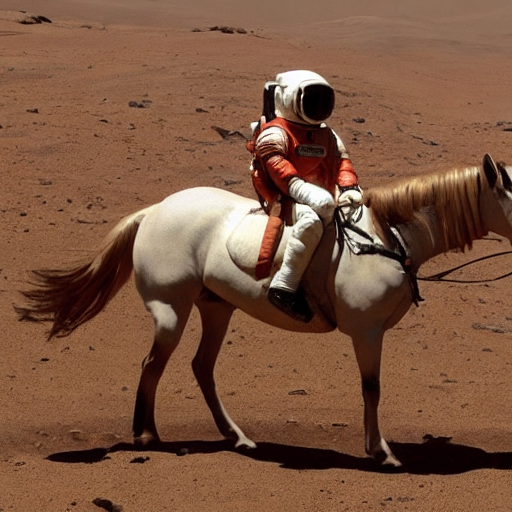

In [49]:
ds_pipeline("a photo of an astronaut riding a horse on mars").images[0]


We managed to accelerate the `CompVis/stable-diffusion-v1-4` pipeline latency from `4.57s` to `2.68s` for generating a `512x512` large image. This results into a 1.7x improvement.

![stable-diffusion-results](../assets/stable-diffusion-improvements.png)

## Conclusion

We successfully optimized our Stable Diffusion with DeepSpeed-inference and managed to decrease our model latency from `4.57s` to `2.68s` or 1.7x.
Those are good results results thinking of that we only needed to add 1 additional line of code, but applying the optimization was as easy as adding one additional call to `deepspeed.init_inference`. 
But I have to say that this isn't a plug-and-play process you can transfer to any Transformers model, task, or dataset. Also, make sure to check if your model is compatible with DeepSpeed-Inference.

If you want to learn more about Stable Diffusion you should check out: 

* [Stable Diffusion with 🧨 Diffusers](https://huggingface.co/blog/stable_diffusion)
* [Stable Diffusion on Amazon SageMaker](https://www.philschmid.de/sagemaker-stable-diffusion)